<h1 align="center" style="margin: 0; font-size: 36px;">Neural and Evolutionary Learning</h1>
<br>
<h1 align="center" style="margin: 0; font-size: 30px;">Project partial deliverable 2 (GSGP)</h1>

<br>

**Group members:**<br>
Bárbara Capitão - 20211532@novaims.unl.pt <br>
Carolina Silvestre - 20211512@novaims.unl.pt <br>
Lara Leandro - 20211632@novaims.unl.pt <br>


### Requirements
- Fit a GSGP to the project dataset, including the hyperparameter tuning phase.
- Discuss the bloat, overfitting, and premature convergence on the algorithm.
- Include your own insights and summary conclusion your

### Table of Contents

[Imports](#chapter_1) <br>
[Settings](#chapter_2) <br>
[Load Data](#chapter_3) <br>
[Data Understanding](#chapter_4) <br>
[Data Preprocessing](#chapter_5) <br>
[Cross-Validation](#chapter_6) <br>
[Genetic Programming](#chapter_7) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Problem Instance Definition](#subchapter_7_1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Solve](#subchapter_7_2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Evolution Graphs](#subchapter_7_3) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Variation of RMSE across Models](#subchapter_7_3_1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Train vs Test Fitness ](#subchapter_7_3_2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Fitness vs Size Evolution](#subchapter_7_3_3) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Entropy](#subchapter_7_3_4) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Fitness Diversity](#subchapter_7_3_5) <br>
[To Evaluate](#chapter_8) <br>

<a id="chapter_1"></a>
## Imports


In [1]:
#! pip install slim_gsgp
#! pip install gplearn

In [1]:
import os
import random
import pickle
import datetime
from itertools import product
from collections import defaultdict

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn 
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Statistical tests
from scipy.stats import spearmanr, shapiro

# Symbolic regression 
from gplearn.genetic import SymbolicRegressor

# Custom modules
from slim_gsgp.datasets.data_loader import *
from slim_gsgp.main_gsgp import gsgp

import joblib


<a id="chapter_2"></a>
## Settings

In [2]:
seed = 43
np.random.seed(seed)

In [3]:
train_color = 'blue'
test_color = 'orange'
size_color = 'green'

<a id="chapter_3"></a>
## Load Data

In [4]:
# Load Excel file
df = pd.read_excel("sustavianfeed.xlsx")

In [5]:
df

,WING TAG,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,EMPTY MUSCULAR STOMACH,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
0,G403,2223.3,1429.6,1725.6,1394.0,214.0,489.4,3.716,38.636,9.305,123.171,/,13.170,86.105469,0.38
1,G439,2201.9,1450.2,1769.8,1405.4,236.0,538.7,3.494,34.725,10.084,71.800,45.273,9.781,86.143472,1.66
2,G454,2159.9,1398.4,1724.9,1461.7,241.8,512.1,4.023,31.932,10.635,61.380,/,6.217,86.416898,0.98
3,G465,2198.7,1473.9,1800.4,1425.1,227.7,549.9,3.087,32.326,11.927,64.879,35.861,8.358,85.959935,1.10
4,G428,2003.2,1291.2,1581.6,1260.1,224.7,473.2,3.723,30.105,9.855,68.562,36.526,7.572,81.693637,6.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,V476,2633.1,1683.2,2034.1,1637.2,213.8,610.9,4.777,45.992,12.796,74.888,54.021,7.857,88.999126,1.07
92,V454,2346.2,1547.8,1819.5,1511.2,228.0,528.2,3.673,35.090,11.504,68.455,42.173,7.837,88.507288,1.13
93,V425,2648.2,1722.9,2050.0,1669.8,253.1,610.0,5.176,50.505,17.194,81.502,49.7,7.332,90.375587,1.91
94,V490,2262.6,1498.5,1813.9,1468.0,212.1,548.4,2.829,30.266,11.129,53.011,46.816,5.425,91.211353,2.21


In [6]:
# Droping ID column
df.drop(columns=['WING TAG'], inplace=True)

<a id="chapter_4"></a>
## Data Understanding

In [7]:
df.describe()

,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,2339.682292,1521.955208,1833.378125,1481.479167,234.116667,542.205208,4.219917,36.781427,12.059240,69.149156,8.184677,87.313708,2.090417
std,200.943424,144.126939,154.000550,142.830115,37.818405,60.994468,0.998836,5.438894,1.932239,11.727467,1.697425,2.043895,1.351645
min,1968.400000,1284.900000,1554.400000,1252.600000,177.100000,177.800000,2.464000,25.916000,8.561000,44.133000,5.425000,73.837184,0.320000
25%,2201.775000,1425.775000,1723.800000,1380.825000,218.775000,508.225000,3.534250,33.053000,10.584250,62.274250,7.012750,86.544416,1.130000
50%,2299.500000,1493.050000,1809.400000,1452.800000,231.550000,538.100000,4.048000,35.936000,11.679000,68.019500,7.809500,87.574947,1.710000
75%,2473.800000,1608.400000,1922.725000,1573.700000,243.275000,573.850000,4.817000,40.485000,13.449750,75.103000,9.016750,88.508026,2.527500
max,2890.500000,1929.400000,2262.800000,1891.700000,533.200000,690.600000,7.758000,53.133000,17.194000,123.171000,13.170000,91.211353,6.680000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   WEIGHT                             96 non-null     float64
 1   HOT CARCASS WEIGHT                 96 non-null     float64
 2   CARCASS WEIGHT WITH HEAD AND LEGS  96 non-null     float64
 3   COLD CARCASS WEIGHT                96 non-null     float64
 4   BREAST WEIGHT (2)                  96 non-null     float64
 5   THIGH WEIGHT (2)                   96 non-null     float64
 6   SPLEEN                             96 non-null     float64
 7   LIVER                              96 non-null     float64
 8   HEART                              96 non-null     float64
 9   INTESTINE                          96 non-null     float64
 10  EMPTY MUSCULAR STOMACH             96 non-null     object 
 11  GLANDULAR STOMACH                  96 non-null     float64
 

> The column 'EMPTY MUSCULAR STOMACH' has been read as type object, possibly because some entries contain non-numeric or unexpected values, preventing it from being interpreted as float

In [9]:
df['EMPTY MUSCULAR STOMACH'].value_counts()

EMPTY MUSCULAR STOMACH
/         5
75.767    2
47.964    1
51.322    1
59.583    1
         ..
63.571    1
49.648    1
43.586    1
53.456    1
46.816    1
Name: count, Length: 91, dtype: int64

> The 'EMPTY MUSCULAR STOMACH' as 5 values '/'

In [10]:
# Coverting the column to numeric, forcing '/' to became Nan
df['EMPTY MUSCULAR STOMACH'] = pd.to_numeric(df['EMPTY MUSCULAR STOMACH'], errors='coerce')

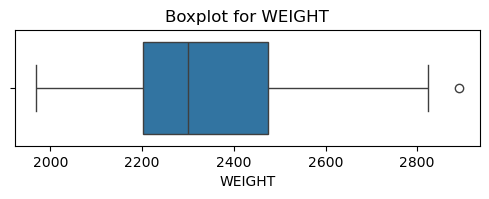

WEIGHT — Outliers detected: 1


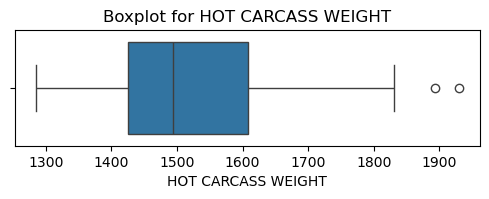

HOT CARCASS WEIGHT — Outliers detected: 2


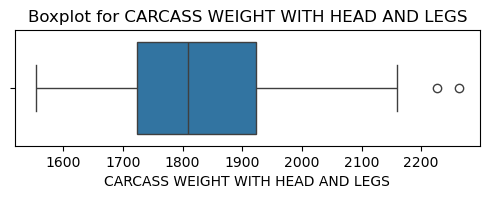

CARCASS WEIGHT WITH HEAD AND LEGS — Outliers detected: 2


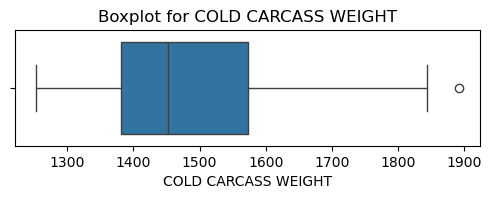

COLD CARCASS WEIGHT — Outliers detected: 1


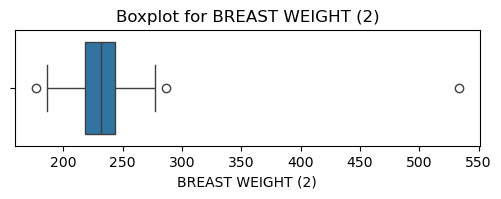

BREAST WEIGHT (2) — Outliers detected: 3


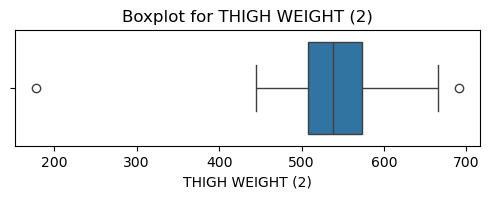

THIGH WEIGHT (2) — Outliers detected: 2


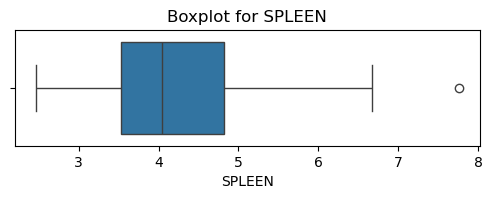

SPLEEN — Outliers detected: 1


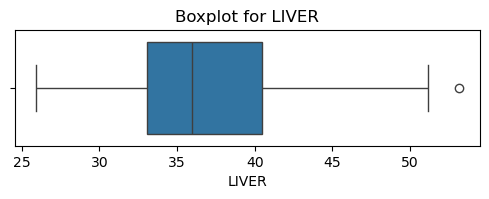

LIVER — Outliers detected: 1


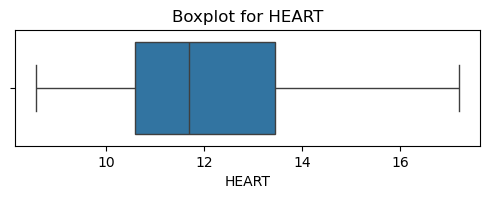

HEART — Outliers detected: 0


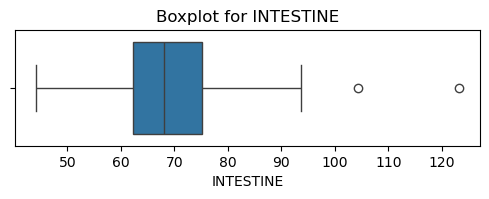

INTESTINE — Outliers detected: 2


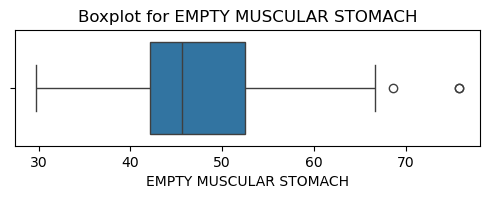

EMPTY MUSCULAR STOMACH — Outliers detected: 3


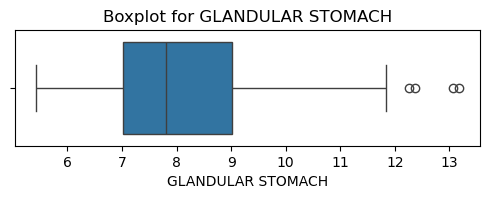

GLANDULAR STOMACH — Outliers detected: 4


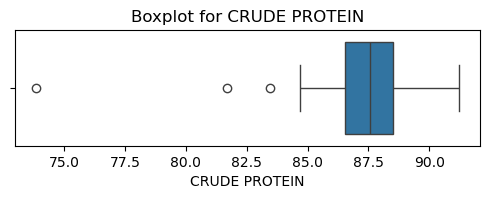

CRUDE PROTEIN — Outliers detected: 3


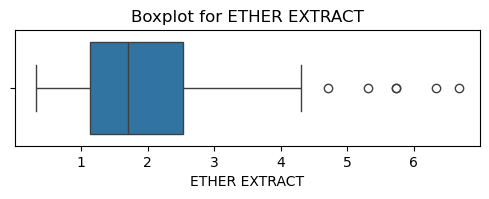

ETHER EXTRACT — Outliers detected: 6


In [11]:
def detect_outliers_iqr(df):
    outlier_info = {}

    for col in df.select_dtypes(include = [np.number] ).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Geting the outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_info[col] = {
            'count': outliers.count(),
            'outliers': outliers.values
        }

        # Ploting the boxplots
        plt.figure(figsize=(6, 1.5))
        sns.boxplot(x=df[col], orient='h' )
        plt.title(f"Boxplot for {col}")
        plt.show()

        print(f"{col} — Outliers detected: {outliers.count()}")
    
    return outlier_info

outlier_summary = detect_outliers_iqr(df)

Most columns contain some outliers, but they are few and not particularly extreme, so we’ve decided to keep them.
The most notable outliers appear in:

- Breast weight: typically ranges from 200–250, but one value is around 550.

- Thigh weight: usually between 450–650, but there's one outlier close to 200.

- Crude protein: generally falls between 85–95, but there's a value near 72.5.


 Analyzing column: WEIGHT


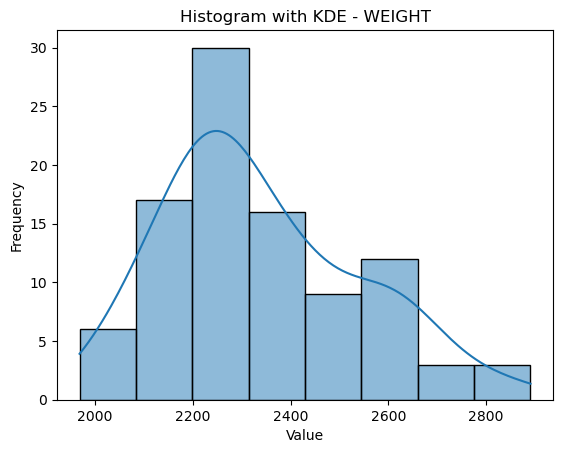

Shapiro-Wilk Test statistic = 0.9641, p-value = 0.0100
 Not normally distributed (reject H0)

 Analyzing column: HOT CARCASS WEIGHT


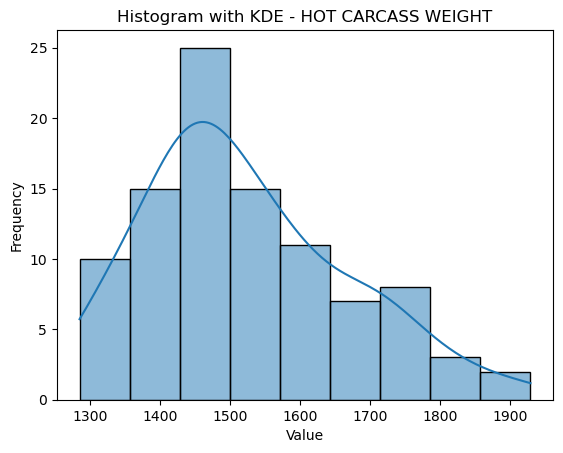

Shapiro-Wilk Test statistic = 0.9611, p-value = 0.0061
 Not normally distributed (reject H0)

 Analyzing column: CARCASS WEIGHT WITH HEAD AND LEGS


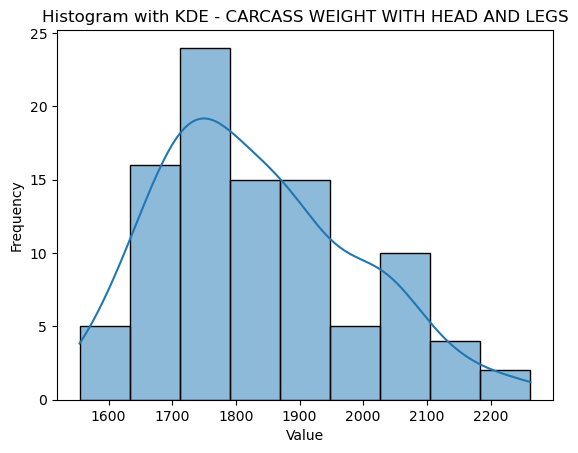

Shapiro-Wilk Test statistic = 0.9641, p-value = 0.0099
 Not normally distributed (reject H0)

 Analyzing column: COLD CARCASS WEIGHT


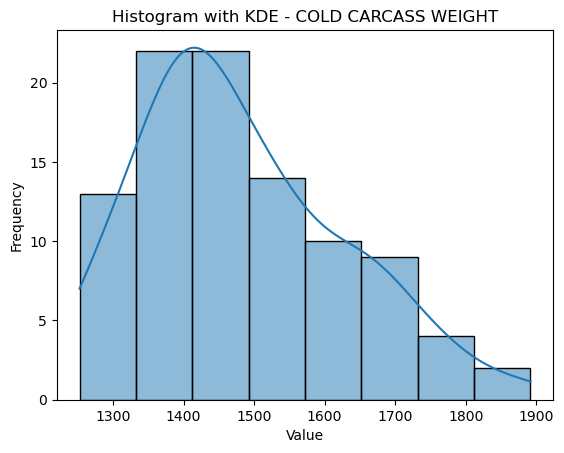

Shapiro-Wilk Test statistic = 0.9577, p-value = 0.0036
 Not normally distributed (reject H0)

 Analyzing column: BREAST WEIGHT (2)


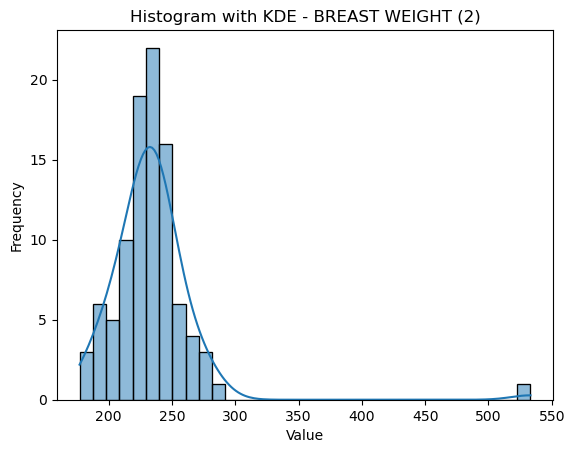

Shapiro-Wilk Test statistic = 0.6057, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: THIGH WEIGHT (2)


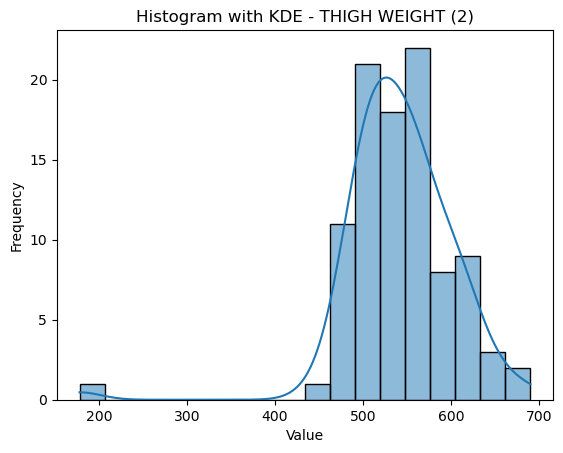

Shapiro-Wilk Test statistic = 0.8492, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: SPLEEN


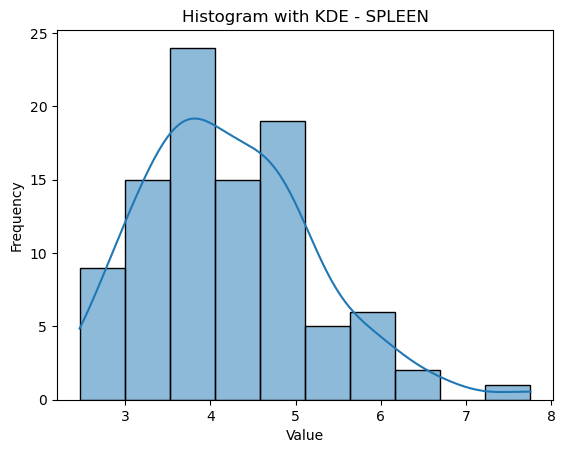

Shapiro-Wilk Test statistic = 0.9657, p-value = 0.0129
 Not normally distributed (reject H0)

 Analyzing column: LIVER


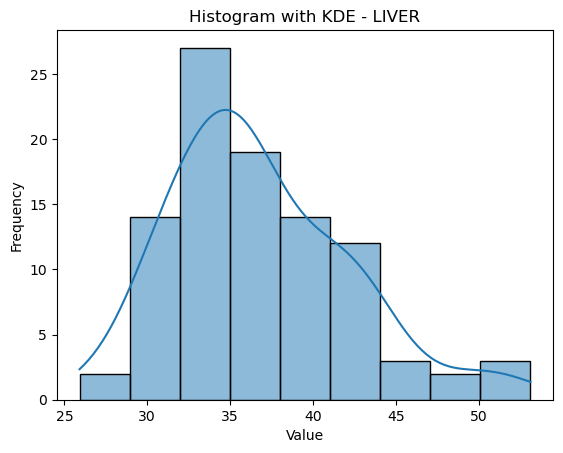

Shapiro-Wilk Test statistic = 0.9633, p-value = 0.0086
 Not normally distributed (reject H0)

 Analyzing column: HEART


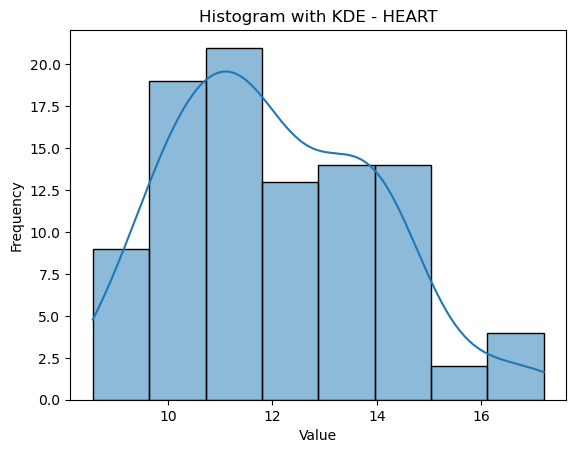

Shapiro-Wilk Test statistic = 0.9730, p-value = 0.0443
 Not normally distributed (reject H0)

 Analyzing column: INTESTINE


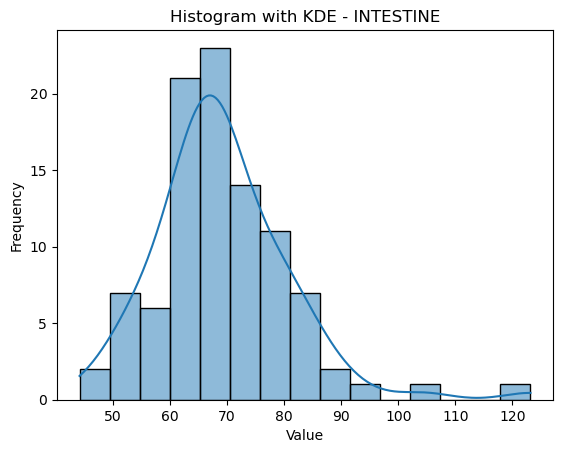

Shapiro-Wilk Test statistic = 0.9302, p-value = 0.0001
 Not normally distributed (reject H0)

 Analyzing column: EMPTY MUSCULAR STOMACH


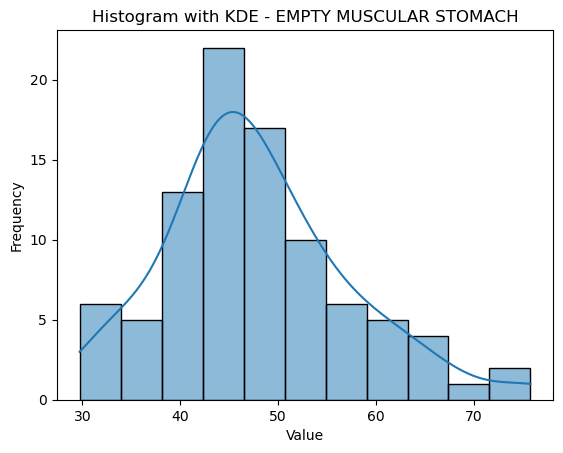

Shapiro-Wilk Test statistic = 0.9656, p-value = 0.0167
 Not normally distributed (reject H0)

 Analyzing column: GLANDULAR STOMACH


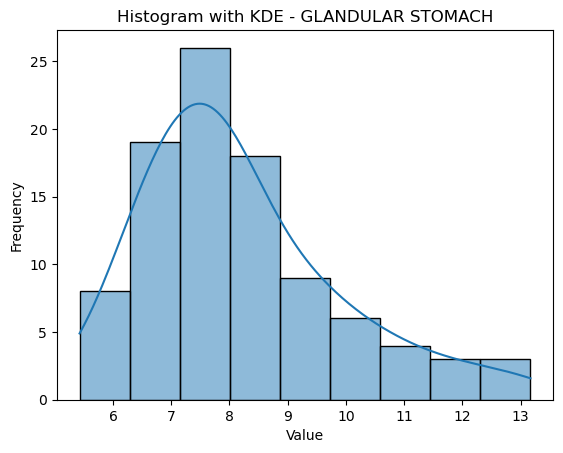

Shapiro-Wilk Test statistic = 0.9303, p-value = 0.0001
 Not normally distributed (reject H0)

 Analyzing column: CRUDE PROTEIN


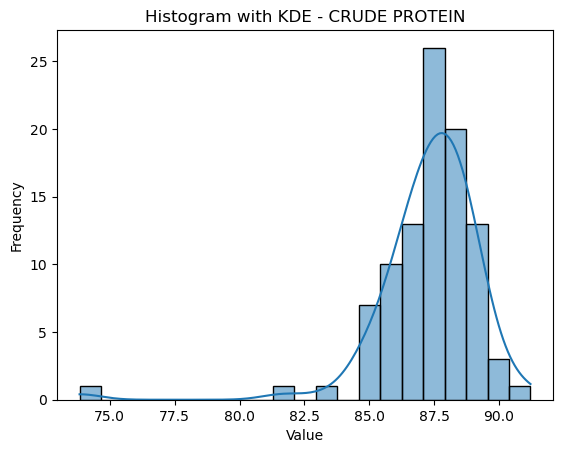

Shapiro-Wilk Test statistic = 0.7674, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: ETHER EXTRACT


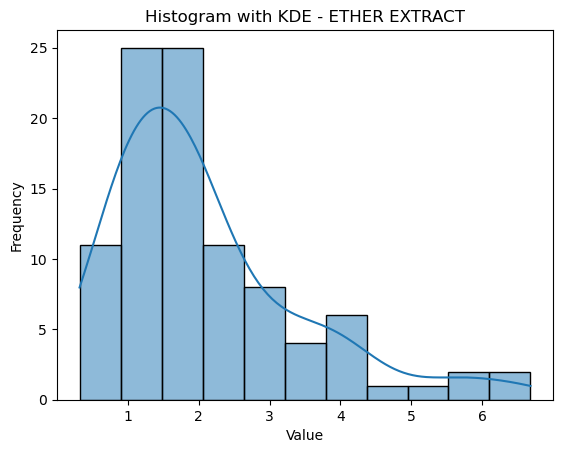

Shapiro-Wilk Test statistic = 0.8674, p-value = 0.0000
 Not normally distributed (reject H0)


In [12]:
# Checking if the data is normally distributed

for column in df.select_dtypes(include=[np.number]).columns:
    print(f"\n Analyzing column: {column}")
    data = df[column].dropna()  

    # Histogram + KDE
    sns.histplot(data, kde=True)
    plt.title(f"Histogram with KDE - {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


    # Shapiro-Wilk Test
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test statistic = {stat:.4f}, p-value = {p:.4f}")
    if p > 0.05:
        print(" Likely normal (fail to reject H0)")
    else:
        print(" Not normally distributed (reject H0)")


All columns in the dataset exhibit non-normal distributions, as confirmed by visual inspection and statistical tests 

<a id="chapter_5"></a>
## Data Preprocessing

In [13]:
# Missing Values
# Calculating the mean
mean_value = df['EMPTY MUSCULAR STOMACH'].mean()

# Replacing the NaNs with the mean
df['EMPTY MUSCULAR STOMACH'] = df['EMPTY MUSCULAR STOMACH'].fillna(mean_value)


In [14]:
# Separating the features from the target
features = df.drop(columns=['CRUDE PROTEIN'])
target = df['CRUDE PROTEIN']

# Scaling the features
scaler = RobustScaler() # since the data is not normally distributed and contains outliers, we opted to use the RobustScaler
X_scaled = scaler.fit_transform(features)


X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32)

<a id="chapter_6"></a>
## Cross-Validation

In [15]:
# Nested Cross Validation
k_outer = 5
k_inner = 3
cv_outer = KFold(n_splits=k_outer, random_state=seed, shuffle=True)
cv_inner = KFold(n_splits=k_inner, random_state=seed, shuffle=True)

We opted to use **nested cross-validation** instead of Monte Carlo because it gives a more confident and reliable estimate of how well the model will perform on new data. The **outer loop** is used to test the model, while the **inner loop** is used for hyperparameter tuning. This setup helps avoid overfitting during tuning and gives a more honest evaluation of the model’s generalization performance.

We chose **5 outer folds** because it gives a good balance between reliable performance estimates and computation time. For the **inner loop**, we used **3 folds** to keep hyperparameter tuning efficient without sacrificing too much accuracy..


<a id="chapter_7"></a>
## Geometric Semantic Genetic Programming

<a id="subchapter_7_1"></a>
### Problem Instance Definition 

In [16]:
DATASET_NAME = 'Sustavian'
FITNESS_FUNCTION = 'rmse'
MINIMIZATION = True

total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	77
Test set:		19
--
Inner Train set:	52
Validation set:		25



<a id="subchapter_7_2"></a>
### Solve 

In [17]:
LOG_DIR = './log/NEL_project/'
LOG_PATH = LOG_DIR + f'gsgp_{DATASET_NAME}.csv'
os.makedirs(LOG_DIR, exist_ok=True)
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)

In [77]:
TREE_CONSTANTS = [random.uniform(0, 1) for _ in range(9)] + [-1.]
TREE_FUNCTIONS = ['add', 'subtract', 'multiply', 'divide']
PROB_CONSTANT = 0.9
MAX_INIT_DEPTH = 4

<p align="left" style="margin: 5; font-size: 20px; font-weight: bold;">Common Problems in GSGP</p>

**Overfitting:**  
THe model fits training data too closely and fails to generalize to new data.

**Bloat:**  
Excessive growth of tree size without fitness improvement making models unnecessarily complex.

**Premature Convergence:**  
Population loses diversity too early and gets stuck in suboptimal solutions.



<p align="left" style="margin: 5; font-size: 20px; font-weight: bold;">Parameters that influence each problem:</p>

- **Overfitting:**  
  - `max_depth`: deeper trees can capture noise -> overfit  
  - `n_elites`: too many elites reduce exploration -> overfit  
  - `p_xo` (crossover rate): low rates limit diversity - overfit  
  - `initializer`: affects initial tree complexity

<p align="left" style="margin: 0; font-size: 10px;"> </p>

- **Bloat:**  
  - `max_depth`: limits max tree size  
  - `initializer`: for example 'grow' creates larger initial trees  
  - `n_elites`: preserves large individuals longer -> bloat  

<p align="left" style="margin: 0; font-size: 10px;"> </p>

- **Premature Convergence:**  
  - `p_xo`: higher crossover keeps diversity  
  - `initializer`: influences initial population diversity  
  - `n_elites`: high elitism reduces diversity too fast  
  - `tournament_size`: bigger tournaments increase selection pressure -> less diversity
 
So our parameter search will focus on these key parameters and the specific parameters of GSGP

In [100]:
#Fixed Parameters

fixed_params = {
    # Search Space
    "init_depth": MAX_INIT_DEPTH,
    "tree_constants": TREE_CONSTANTS,
    "tree_functions": TREE_FUNCTIONS,
    "prob_const": PROB_CONSTANT,
    
    # Problem Instance
  
    "dataset_name": DATASET_NAME,
    "fitness_function": FITNESS_FUNCTION,
    "minimization": MINIMIZATION,

    # Solve settings
    "elitism": True,
    "n_iter": 20,
    "test_elite": True,
    "log_path": LOG_PATH,
    "log_level": 2,
    "verbose": 1,
    "n_jobs": 1,
    "seed": seed, 

    # GSGP Instance
    "pop_size": 1000,
    "tournament_size": 7,
  #  "initializer": 'rhh',
    "ms_lower": 0,
  #  "ms_upper": 1,
    "reconstruct": True,
    'elitism': True,


}

# Parameters Grid Search

param_grid = {


    # GSGP Instance
    "initializer": ['grow','rhh'],
  #  'pop_size': [100, 200],
    'p_xo': [ 0.5, 0.9],
 #  'tournament_size': [3, 5],
 #  'ms_lower': [0.01, 0.05],
    'ms_upper': [1, 2],

    # Solve settings
    "n_elites": [1, 3]
}


In [101]:
def call_gsgp(fixed_params, param_grid, seed, set_max_depth = False):
    models = []
    keys, values = zip(*param_grid.items())
    for combo in product(*values):
        dynamic_params = dict(zip(keys, combo))
        full_params = {**fixed_params, **dynamic_params}
        if set_max_depth:
            full_params.update({'max_depth': full_params['init_depth']+15})
        model = gsgp(**full_params)
        res = {'model': model}
        res.update({'rmse_train': model.fitness.item()})
        res.update({'rmse_test': model.test_fitness.item()})
        res.update({'dynamic_params': dynamic_params})
        models.append(res)
    return models      


In [102]:
# Outer CV loop

data_cv_outer = [[learning_ix, test_ix] for learning_ix, test_ix in cv_outer.split(X, y)][0]

# Spliting the outer loop data
learning_ix, test_ix = data_cv_outer
X_learning, y_learning = X[learning_ix], y[learning_ix]
X_test, y_test = X[test_ix], y[test_ix]

print('\n' + '-'*41 + '\n')
print(f'Outer CV\nLearning shape: {X_learning.shape}\nTest shape: {X_test.shape}\n')

# Inner CV loop
results = []
data_cv_inner = [[train_ix, val_ix] for train_ix, val_ix in cv_inner.split(X_learning, y_learning)]

for i_inner, (train_ix, val_ix) in enumerate(data_cv_inner):
    print('-----\nInner CV {}'.format(i_inner))

    # Spliting inner data
    X_train, y_train = X_learning[train_ix], y_learning[train_ix]
    X_val, y_val = X_learning[val_ix], y_learning[val_ix]

    print(f'Training shape: {X_train.shape}\nValidation shape: {X_val.shape}\n')

    fixed_params.update({
        'X_train': X_train, 'y_train': y_train,
        'X_test': X_val, 'y_test': y_val,
    })

    # Fit
    LOG_PATH = LOG_DIR+'gsgp_'+DATASET_NAME+'_'+str(i_inner)+'.csv'
    if os.path.exists(LOG_PATH):
        os.remove(LOG_PATH)
    fixed_params.update({'log_path': LOG_PATH})

    # Running the model
    res = call_gsgp(fixed_params, param_grid, seed=(seed + i_inner))

    # Collecting results
    results.append(res)



-----------------------------------------

Outer CV
Learning shape: torch.Size([76, 13])
Test shape: torch.Size([20, 13])

-----
Inner CV 0
Training shape: torch.Size([50, 13])
Validation shape: torch.Size([26, 13])

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     Sustavian           |       0      |   79.38658905029297   |   79.67854309082031      |   1.003835916519165    |      5           |
|     Sustavian           |       1      |   79.38658905029297   |   79.67854309082031      |   1.2804920673370361   |      5           |
|     Sustavian           |       2      |   79.00325775146484   |   79.293

In [103]:
# Getting the best model

all_models = [model for fold_result in results for model in fold_result]

# Sort by test RMSE 
sorted_models = sorted(all_models, key=lambda x: x['rmse_test'])

best_model = sorted_models[0]

print('\n Best Model Found:')
print(f"  RMSE (Train): {best_model['rmse_train']:.4f}")
print(f"  RMSE (Test):  {best_model['rmse_test']:.4f}")
print(f"  Parameters:   {best_model['dynamic_params']}")



 Best Model Found:
  RMSE (Train): 0.9540
  RMSE (Test):  0.7823
  Parameters:   {'initializer': 'rhh', 'p_xo': 0.5, 'ms_upper': 1, 'n_elites': 3}


In [106]:
model = best_model['model']

In [107]:
y_pred = model.predict(X_test)
y_pred

tensor([88.0626, 87.1337, 87.5751, 86.9789, 87.5208, 87.3319, 86.1953, 86.2137,
        87.6205, 86.4298, 85.6216, 87.2702, 88.8734, 88.3604, 86.3081, 87.6907,
        87.2928, 88.4854, 85.4283, 87.9590])

In [108]:
y_test

tensor([86.1055, 86.1435, 86.4169, 87.5331, 88.1924, 86.2464, 86.5115, 84.9951,
        88.9662, 87.1134, 73.8372, 86.5774, 87.3628, 88.5818, 86.0451, 87.2786,
        87.6940, 88.6367, 86.5774, 87.4385])

<a id="subchapter_7_3"></a>
### Evolution Graphs

In [109]:
pd.read_csv(LOG_PATH, header=None).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,StandardGSGP,81882e95-3315-11f0-a9d7-00f48dd34ab0,Sustavian,43,0,79.556190,0.596893,3724.0,79.344398,5,tensor(12.2717),1.049689,2
1,StandardGSGP,81882e95-3315-11f0-a9d7-00f48dd34ab0,Sustavian,43,1,79.556190,1.260581,15812.0,79.344398,5,tensor(9.1378),1.156061,2
2,StandardGSGP,81882e95-3315-11f0-a9d7-00f48dd34ab0,Sustavian,43,2,79.175018,1.193915,34488.0,78.955322,27,tensor(11.3949),1.379470,2
3,StandardGSGP,81882e95-3315-11f0-a9d7-00f48dd34ab0,Sustavian,43,3,78.906212,1.481350,60340.0,78.686554,35,tensor(9.3286),1.087208,2
4,StandardGSGP,81882e95-3315-11f0-a9d7-00f48dd34ab0,Sustavian,43,4,78.688332,1.661203,87524.0,78.468689,41,tensor(6.1378),0.693069,2


<a id="subchapter_7_3_1"></a>
#### Variation of RMSE across Models

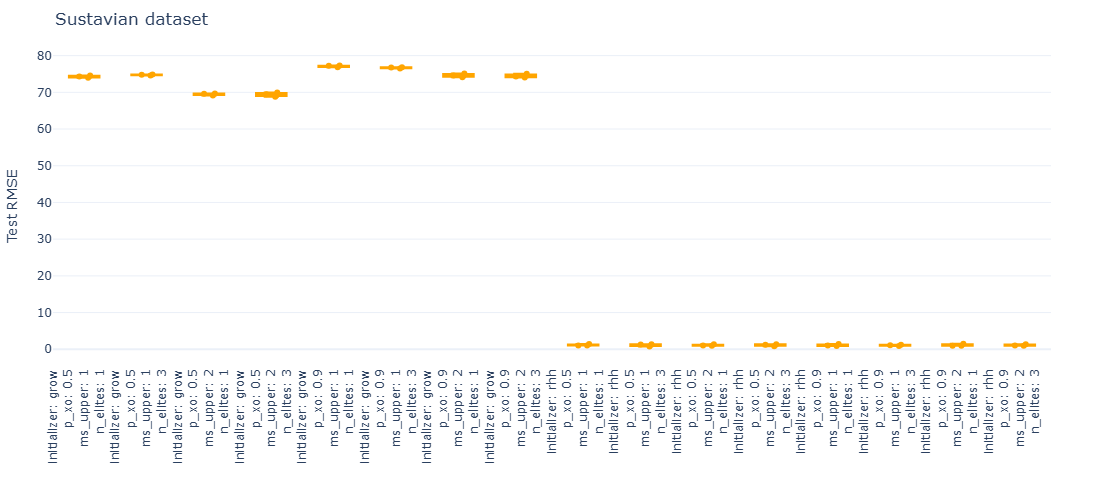

In [110]:
# Boxplots for comparison of Test RMSE Distributions across Model 

rmse_by_config = defaultdict(list)

for split in results:
    rmse_train = []
    rmse_test = []
    
    for result in split:
        key = ''
        for k, v in result['dynamic_params'].items():
            key += k+': '+str(v)+' <br /> '
        rmse_by_config[key].append(result['rmse_test'])

fig = go.Figure()
for config, rmse_values in rmse_by_config.items():
    fig.add_trace(go.Box(
        y=rmse_values,
        boxpoints='all',
        jitter=0.5,
        pointpos=0,
        line=dict(color='orange'),
        name=config
    ))

fig.update_layout(
    title=DATASET_NAME+' dataset',
    xaxis_title='',
    yaxis_title='Test RMSE',
    height=500, width=1100,
    xaxis_tickangle=-90,
    yaxis_range=[0,None],
    margin=dict(l=50, r=50, t=50, b=20),
    showlegend=False,
    template='plotly_white'
)

fig.show()

We can clearly see that using `grow` as the initializer yields significantly worse results with GSGP compared to `rhh` (ramped half-and-half). This is likely due to the fact that `grow` tends to produce highly unbalanced and shallow trees, which limits the diversity and expressive power of the initial population. Since GSGP relies heavily on semantic variation, a poorly diversified starting population can hinder both exploration and the algorithm's ability to evolve effective solutions, leading to early convergence and suboptimal generalization.

In contrast, the other hyperparameters tested appear to have a less pronounced effect on performance. Once the impact of the initialization method is accounted for, the test RMSE distributions across these settings remain relatively similar, as shown by the boxplots.

<a id="subchapter_7_3_2"></a>
#### Train vs Test Fitness 

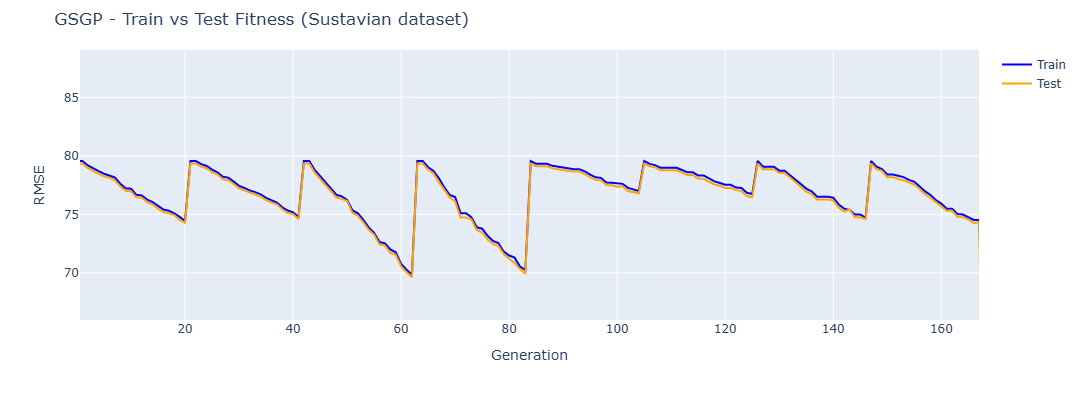

In [112]:
# General graph

fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,5].values, 
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,8].values, 
                         mode='lines', name='Test', line=dict(color=test_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    yaxis_range=[0,None],
    title_text='GSGP - Train vs Test Fitness ('+DATASET_NAME+' dataset)',
    xaxis_title='Generation', yaxis_title='RMSE'
)
fig.update_yaxes(range=[0, None])
fig.show()



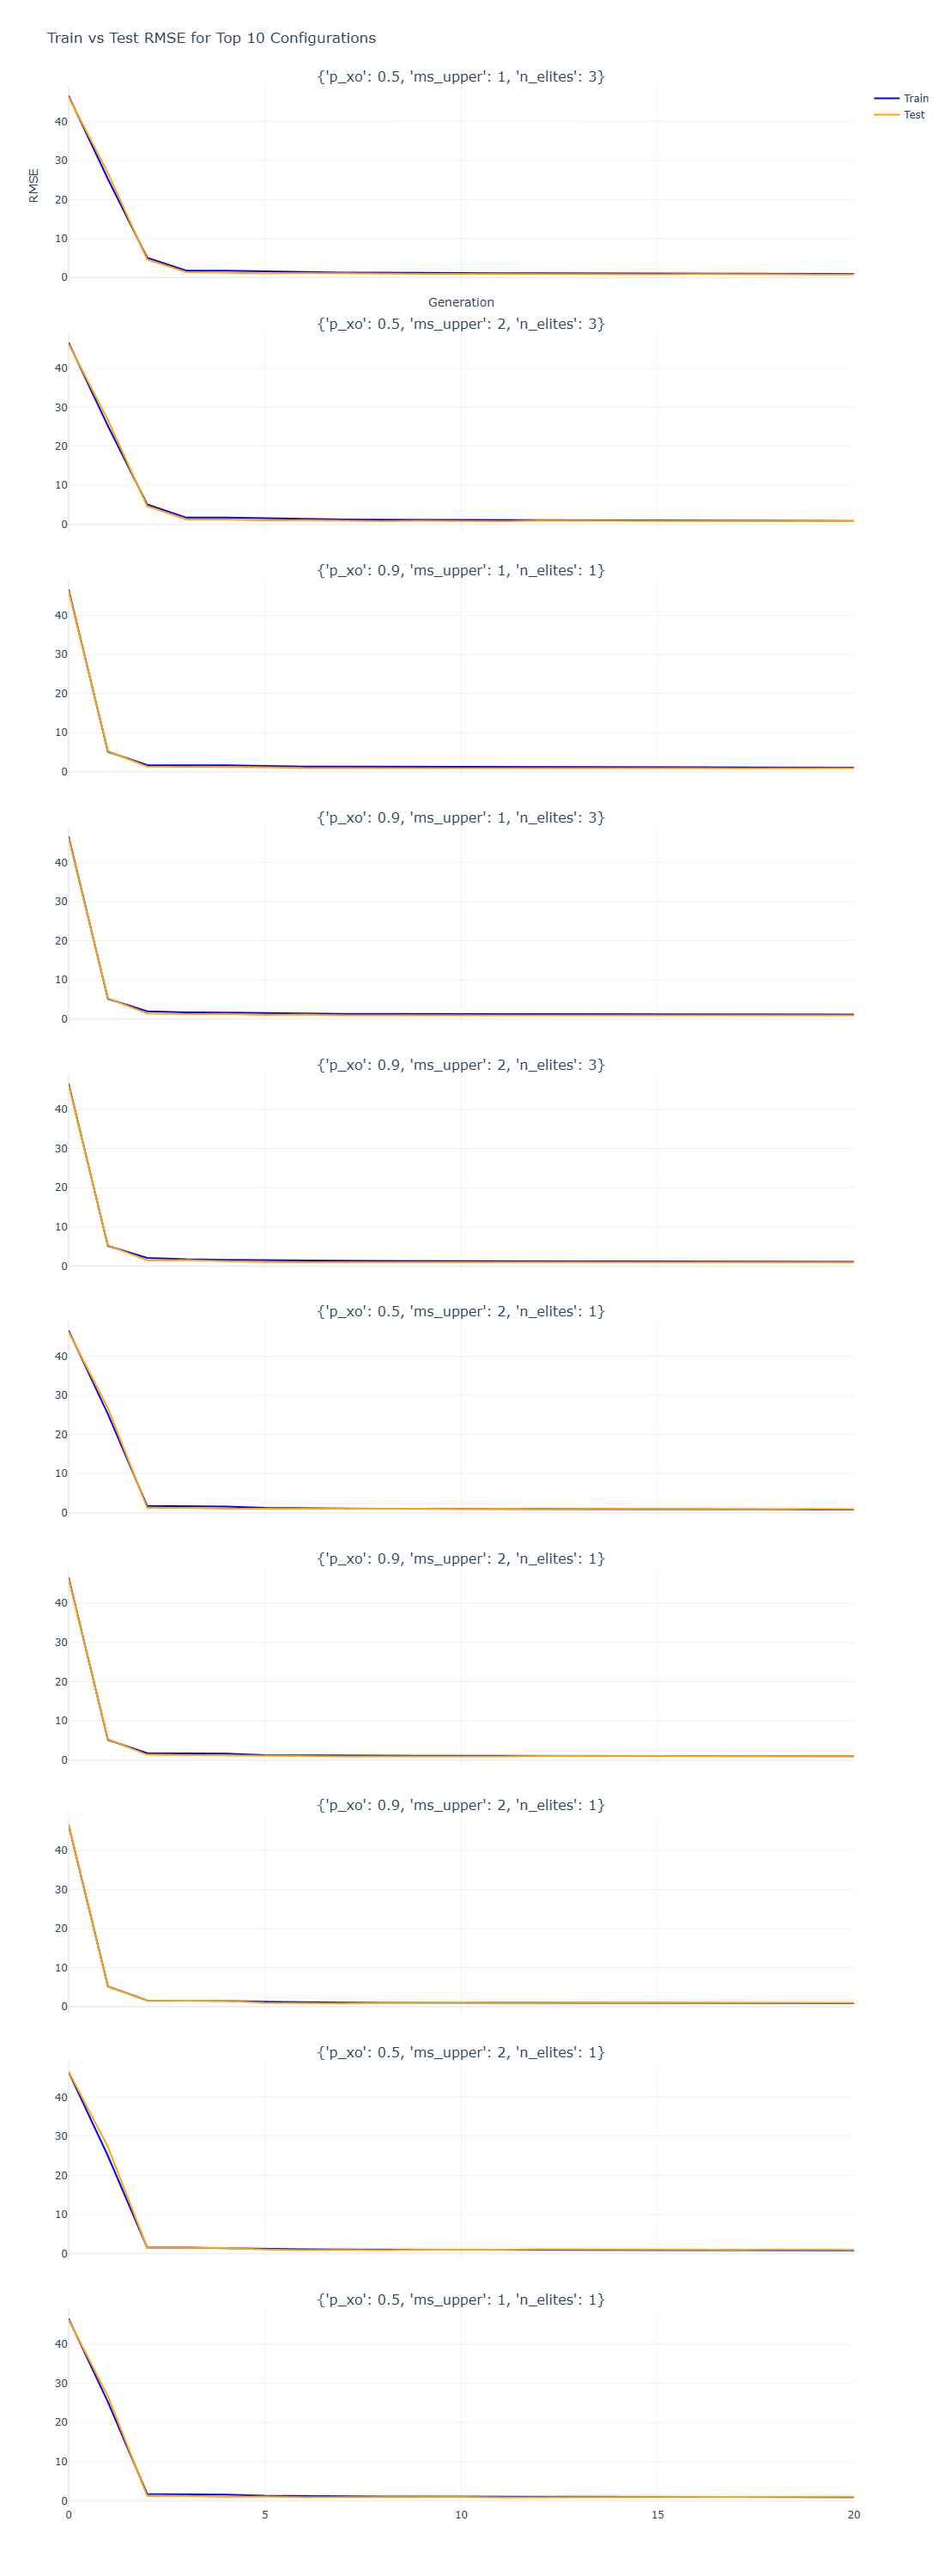

In [90]:
# Some subplots

# Flatten results, keep original config index within each fold
flat_results = []
for fold_id, fold in enumerate(results):
    for config_idx, res in enumerate(fold):
        flat_results.append((fold_id, config_idx, res))

# Sort by test RMSE 
flat_results.sort(key=lambda x: x[2]['rmse_test'])

# Take top N
N = 10
flat_results = flat_results[:N]

GENS_PER_RUN = fixed_params['n_iter'] + 1

fig = make_subplots(
    rows=N, cols=1, shared_xaxes=True,
    subplot_titles=[str(res['dynamic_params']) for _, _, res in flat_results],
    vertical_spacing=0.02
)

for idx, (fold_id, config_idx, result) in enumerate(flat_results):
    LOG_PATH = f'{LOG_DIR}gsgp_{DATASET_NAME}_{fold_id}.csv'
    if not os.path.exists(LOG_PATH):
        continue

    log_df = pd.read_csv(LOG_PATH, header=None)

    # Use original config_idx to slice the right chunk in the log
    start = config_idx * GENS_PER_RUN
    end = start + GENS_PER_RUN
    chunk = log_df.iloc[start:end]

    fig.add_trace(go.Scatter(
        y=chunk.iloc[:, 5],  # Train RMSE
        mode='lines', name='Train' if idx == 0 else None,
        showlegend=(idx == 0),
        line=dict(color=train_color)
    ), row=idx + 1, col=1)

    fig.add_trace(go.Scatter(
        y=chunk.iloc[:, 8],  # Test RMSE
        mode='lines', name='Test' if idx == 0 else None,
        showlegend=(idx == 0),
        line=dict(color=test_color)
    ), row=idx + 1, col=1)

fig.update_layout(
    height=300 * N,
    width=1000,
    title_text=f'Train vs Test RMSE for Top {N} Configurations',
    xaxis_title='Generation',
    yaxis_title='RMSE',
    template='plotly_white',
    showlegend=True
)

fig.show()


In the Train vs Test RMSE plots, both curves are nearly overlapping across generations, indicating strong generalization and minimal overfitting.

Configurations initialized with `grow` show a slower, modest improvement, starting around RMSE 80 and declining only slightly, this suggests limited early progress, possibly due to the unbalanced and shallow trees commonly produced by `grow`, which may reduce the initial diversity. In contrast, rhh initializations show a sharp drop from around 46 to near 1–2 by the second generation, suggesting very early convergence. While efficient, this may indicate premature convergence, limiting further evolution and risking suboptimal solutions.

<a id="subchapter_7_3_3"></a>
#### Fitness vs Size Evolution

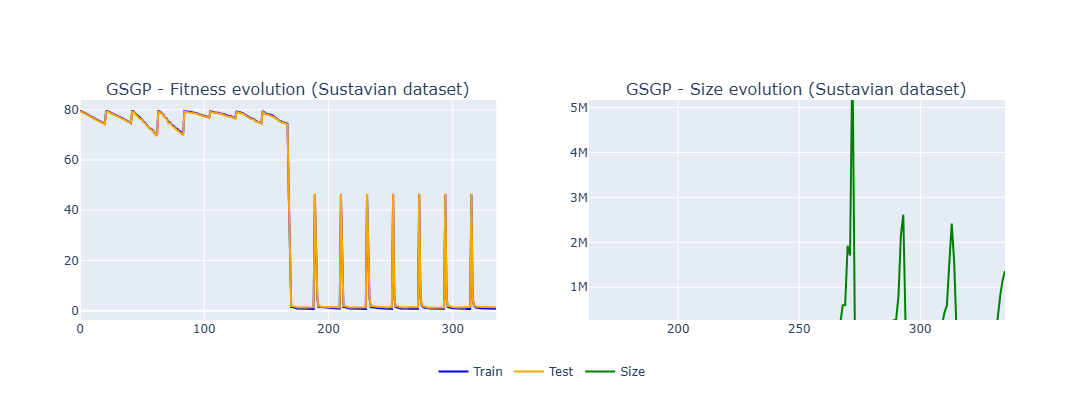

In [113]:
# General graph
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('GSGP - Fitness evolution ('+DATASET_NAME+' dataset)', 'GSGP - Size evolution ('+DATASET_NAME+' dataset)')
)

fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,5].values, 
                         mode='lines', name='Train', line=dict(color=train_color)), row=1, col=1)
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,8].values, 
                         mode='lines', name='Test', line=dict(color=test_color)), row=1, col=1)
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,9].values, 
                         mode='lines', name='Size',line=dict(color=size_color)), row=1, col=2)
fig.update_layout(
    width=1000,
    height=400, 
    showlegend=True,
    yaxis_range=[0,None],
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    )
)
fig.show()


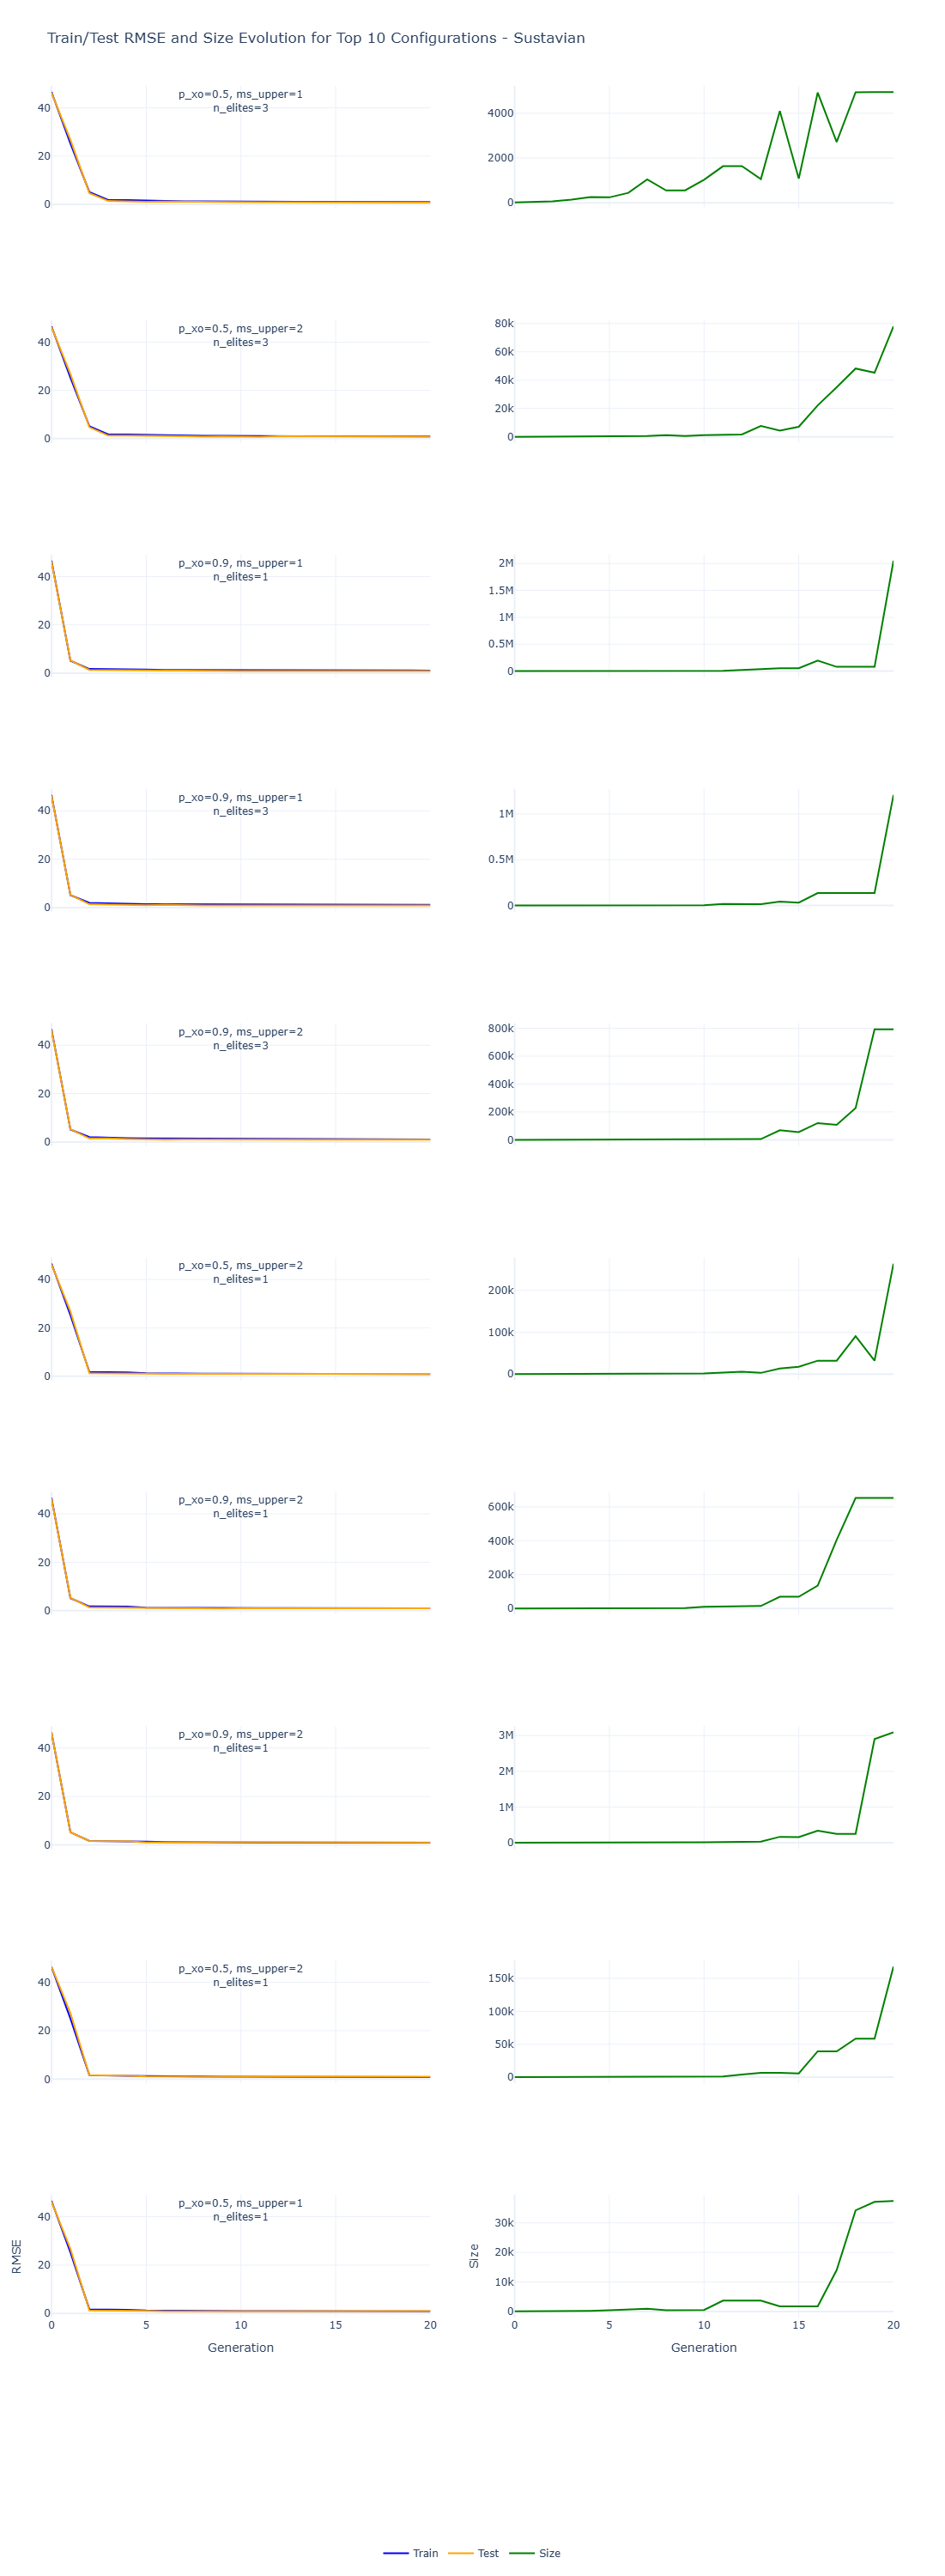

In [92]:
def param_title_str_multiline(params):
    items = [f"{k}={v}" for k, v in params.items()]
    half = (len(items) + 1) // 2
    first_line = ", ".join(items[:half])
    second_line = ", ".join(items[half:])
    return first_line + "<br>" + second_line if second_line else first_line

# Take top N
N = 10
flat_results = flat_results[:N]

GENS_PER_RUN = fixed_params['n_iter'] + 1

fig = make_subplots(
    rows=N, cols=2,
    shared_xaxes=True,
    horizontal_spacing=0.1,
    vertical_spacing=0.05,
    column_widths=[0.45, 0.45]
)

for idx, (fold_id, config_idx, result) in enumerate(flat_results):
    LOG_PATH = f'{LOG_DIR}gsgp_{DATASET_NAME}_{fold_id}.csv'
    if not os.path.exists(LOG_PATH):
        print(f"Missing log for fold {fold_id}, skipping.")
        continue

    log_df = pd.read_csv(LOG_PATH, header=None)

    start = config_idx * GENS_PER_RUN
    end = start + GENS_PER_RUN
    chunk = log_df.iloc[start:end]

    show_legend = idx == 0

    # Train RMSE
    fig.add_trace(go.Scatter(
        y=chunk.iloc[:, 5],
        mode='lines',
        name='Train',
        line=dict(color=train_color),
        showlegend=show_legend
    ), row=idx + 1, col=1)

    # Test RMSE
    fig.add_trace(go.Scatter(
        y=chunk.iloc[:, 8],
        mode='lines',
        name='Test',
        line=dict(color=test_color),
        showlegend=show_legend
    ), row=idx + 1, col=1)

    # Size
    fig.add_trace(go.Scatter(
        y=chunk.iloc[:, 9],
        mode='lines',
        name='Size',
        line=dict(color=size_color),
        showlegend=show_legend
    ), row=idx + 1, col=2)

    # Parameters annotation
    fig.add_annotation(
        x=0.5,
        y=1,
        xref=f"x domain",
        yref=f"y domain",
        text=param_title_str_multiline(result['dynamic_params']),
        showarrow=False,
        font=dict(size=12),
        align='center',
        row=idx + 1, col=1
    )

fig.update_layout(
    height=300 * N,
    width=1100,
    title_text=f'Train/Test RMSE and Size Evolution for Top {N} Configurations - {DATASET_NAME}',
    template='plotly_white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=-0.1,
        xanchor='center',
        x=0.5,
        font=dict(size=12),
        bgcolor='rgba(0,0,0,0)'
    ),
    margin=dict(b=150, l=60, r=60, t=100)
)

fig.update_xaxes(title_text='Generation', row=N, col=1)
fig.update_xaxes(title_text='Generation', row=N, col=2)
fig.update_yaxes(title_text='RMSE', row=N, col=1)
fig.update_yaxes(title_text='Size', row=N, col=2)

fig.show()


While the Train and Test RMSE remain nearly constant after the initial drop, the number of nodes grows significantly in later generations. This indicates bloat, meaning the growing model size offers little added value and may hurt interpretability without boosting fitness.


<a id="subchapter_7_3_4"></a>
#### Semantic Diversity

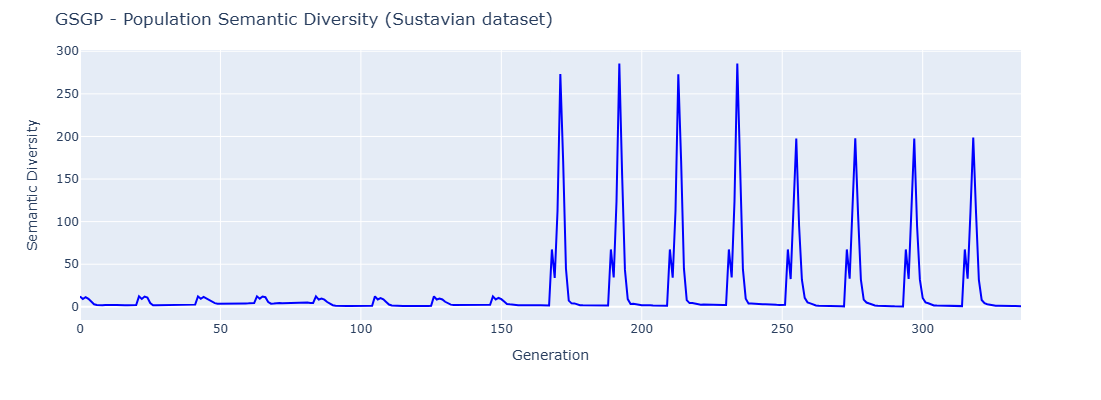

In [115]:
fig = go.Figure()
div_vector_log = pd.read_csv(LOG_PATH, header=None).iloc[:,10].values
div_vector_values = np.array([float(x.replace('tensor(', '').replace(')', '')) for x in div_vector_log])
fig.add_trace(go.Scatter(y=div_vector_values,
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    title_text='GSGP - Population Semantic Diversity ('+DATASET_NAME+' dataset)',
    yaxis_range=[0,None],
    xaxis_title='Generation', yaxis_title='Semantic Diversity'
)
fig.show()

In the early generations, which correspond to the `grow` initializer, we see low semantic diversity. indicating limited exploration and a lack of variety in behavior across individuals. This suggests that the initial population is not semantically rich, which can constrain the algorithm’s ability to discover diverse solutions.

In contrast, in the generations initialized by `rhh`, we start to notice regular spikes in semantic diversity. These bursts show times when there’s increase in behavioral variation in the population, which is important for evolution in GSGP. 

Interestingly, when combining `rhh` with a high crossover probability (`p_xo` = 0.90), the semantic diversity peaks are noticeably lower than those observed with a lower crossover rate (`p_xo` = 0.50). This may suggest that overly aggressive crossover disrupts meaningful variation and leads to more homogenized offspring, ultimately reducing the effectiveness of semantic exploration.

<a id="subchapter_7_3_5"></a>
#### Fitness Diversity

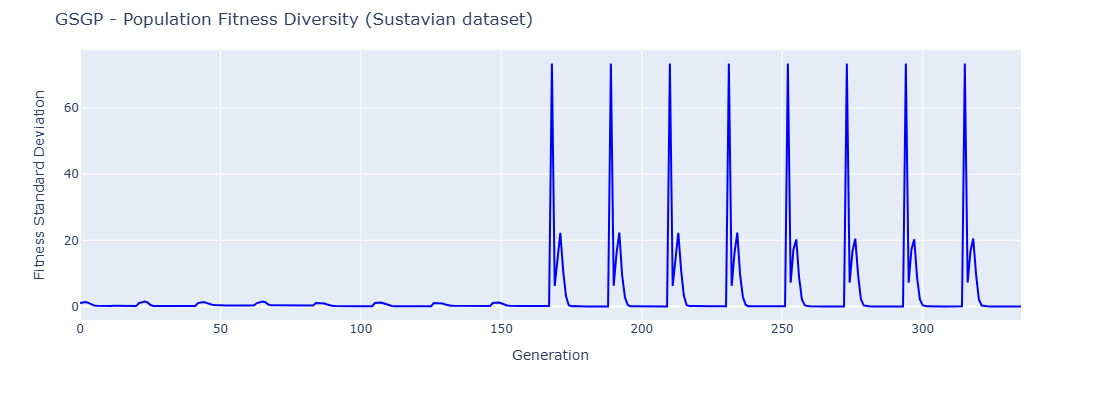

In [114]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,11].values, 
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    yaxis_range=[0,None],
    title_text='GSGP - Population Fitness Diversity ('+DATASET_NAME+' dataset)',
    xaxis_title='Generation', yaxis_title='Fitness Standard Deviation'
)
fig.show()


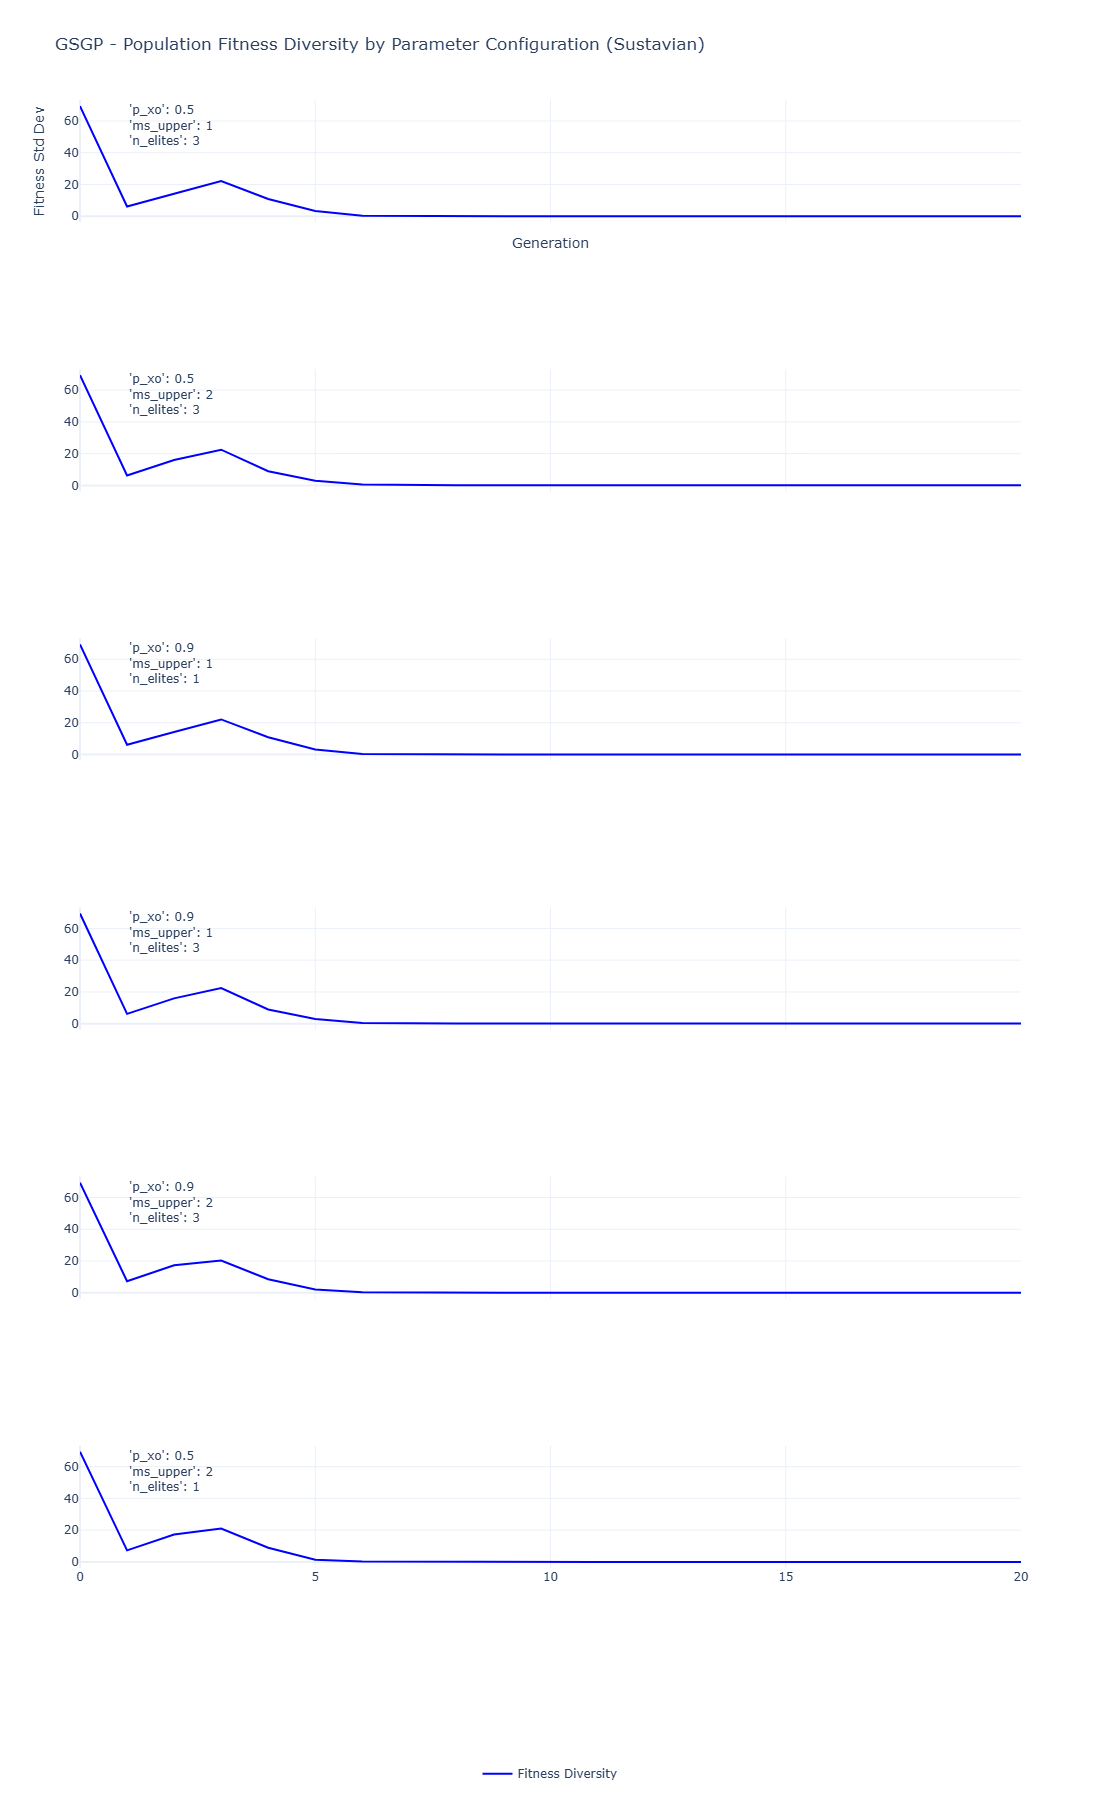

In [96]:
N = 6
GENS_PER_RUN = fixed_params['n_iter'] + 1

fig = make_subplots(
    rows=N, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=[""] * N 
)

fold_seen_count = {}

for idx, (fold_id, config_idx, result) in enumerate(flat_results[:N]):
    LOG_PATH = f'{LOG_DIR}gsgp_{DATASET_NAME}_{fold_id}.csv'
    if not os.path.exists(LOG_PATH):
        continue

    log_df = pd.read_csv(LOG_PATH, header=None)

    seen = fold_seen_count.get(fold_id, 0)
    fold_seen_count[fold_id] = seen + 1

    start = seen * GENS_PER_RUN
    end = start + GENS_PER_RUN
    chunk = log_df.iloc[start:end]

    fitness_diversity = chunk.iloc[:, 11].values

    fig.add_trace(go.Scatter(
        y=fitness_diversity,
        mode='lines',
        name='Fitness Diversity' if idx == 0 else None,
        line=dict(color='blue'),
        showlegend=(idx == 0)
    ), row=idx + 1, col=1)

    # Parameter configoration above plot
    param_lines = str(result['dynamic_params']).replace('{', '').replace('}', '').split(',')
    param_text = '<br>'.join(p.strip() for p in param_lines)

    fig.add_annotation(
    text=param_text,
    x=0.05,
    xref=f"x domain",
    yref=f"y domain",
    y=1, 
    showarrow=False,
    font=dict(size=12),
    align='left',
    row=idx + 1, col=1

    )

fig.update_layout(
    height=300 * N,
    width=900,
    title_text=f'GSGP - Population Fitness Diversity by Parameter Configuration ({DATASET_NAME})',
    xaxis_title='Generation',
    yaxis_title='Fitness Std Dev',
    template='plotly_white',
    showlegend=True,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.15,
        xanchor='center',
        x=0.5,
        font=dict(size=12)
    ),
    margin=dict(t=100, b=100)
)

fig.show()


In the plot of population fitness diversity, the early generations, corresponding to the `grow` initialization, show very low standard deviation, indicating low diversity within the population. In contrast, the later generations initialized with `rhh` display periodic spikes in diversity, suggesting bursts of variation introduced during evolution.

This supports the idea that `rhh` fosters more diverse populations, which helps maintain exploration. In contrast, the lack of diversity with grow may explain its poorer performance due to limited search space coverage.

#### Summary

**Bloat** <br>
With rhh, node counts grow significantly after early RMSE improvements, even though fitness stays constant. Classic bloat—larger models with no real gain, reducing interpretability.

**Overfitting**<br>
Overfitting is minimal. Train and Test RMSE curves are nearly identical across generations, showing good generalization, even in bloated models.

**Early Convergence**<br>
Grow: Shallow, unbalanced trees lead to limited early progress and low diversity.<br>
Rhh: RMSE drops sharply by Gen 2, showing early convergence, which may limit long-term performance.

<a id="chapter_8"></a>
### To Evaluate

We will use these evaluation metrics, MAE, MSE, and correlation coefficients, to measure the performance of each algorithm. After calculating these metrics, we will apply statistical tests to determine whether the observed differences in performance are statistically significant, following the approach recommended by Rainio et al. (2024).


In [97]:
# Converting PyTorch tensors to NumPy arrays

y_true_np = y_test.detach().cpu().numpy()
y_pred_np =  y_pred.detach().cpu().numpy()

In [98]:
# Computing Spearman's rank correlation
spearman_corr_gsgp, _ = spearmanr(y_true_np, y_pred_np)

print("Spearman’s correlation (rs):", spearman_corr_gsgp)

Spearman’s correlation (rs): 0.5535916149295645


In [99]:
# Computing MAE and MSE
mae_gsgp = mean_absolute_error(y_true_np, y_pred_np)
mse_gsgp = mean_squared_error(y_true_np, y_pred_np)

print("MAE:", mae_gsgp)
print("MSE:", mse_gsgp)


MAE: 1.3543617725372314
MSE: 7.782508850097656
